# Credit Card Fraud Detection

In [37]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualization'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn import set_config;  set_config(display = 'diagram')

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Normalization
from tensorflow.keras.metrics import Recall, Precision

In [2]:
# Load data
df = pd.read_csv("creditcard.csv")

In [3]:
# Select data
X = df.drop(columns=['Class'],axis=1).values
y = df['Class'].values

## 1. Rebalancing classes

In [4]:
# Let's check class balance
pd.Series(y).value_counts(normalize=True)

0    0.998273
1    0.001727
Name: proportion, dtype: float64

☝️ in this `fraud detection` dataset, **the classes are extremely imbalanced**:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

**We are going to rebalance the dataset**


In [5]:
# Train test split before any resampling to keep real test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3,stratify=y_train)

In [7]:
print(f"X_train.shape = {X_train.shape}")
print(f"y_train.shape = {y_train.shape}")
print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")
print(f"X_test.shape = {X_test.shape}")
print(f"y_test.shape = {y_test.shape}")

X_train.shape = (139554, 30)
y_train.shape = (139554,)
X_val.shape = (59810, 30)
y_val.shape = (59810,)
X_test.shape = (85443, 30)
y_test.shape = (85443,)


In [8]:
# How many "fraud" samples are there in each split?
print(np.sum(y_train[y_train == 1]))
print(np.sum(y_val[y_val == 1]))
print(np.sum(y_test[y_test == 1]))

print("-"*100)

print(f"There are {pd.Series(y_train).value_counts()[1]} fraudulent transactions in the train set")
print(f"There are {pd.Series(y_val).value_counts()[1]} fraudulent transactions in the val set")
print(f"There are {pd.Series(y_test).value_counts()[1]} fraudulent transactions in the test set")

241
103
148
----------------------------------------------------------------------------------------------------
There are 241 fraudulent transactions in the train set
There are 103 fraudulent transactions in the val set
There are 148 fraudulent transactions in the test set


In [9]:
# Sampling strategies
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.33)

In [38]:

# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
pipeline

Pipeline(steps=[('o', SMOTE(sampling_strategy=0.1)),
                ('u', RandomUnderSampler(sampling_strategy=0.33))])

In [11]:
# Rebalance the dataset
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

print(f"X_train_resampled.shape = {X_train_resampled.shape}")
print(f"y_train_resampled.shape = {y_train_resampled.shape}")

X_train_resampled.shape = (56146, 30)
y_train_resampled.shape = (56146,)


In [12]:
# Reshuffle the resampled data just to be sure
stacked_resampled_data = np.hstack([X_train_resampled, y_train_resampled.reshape(-1,1)])
np.random.shuffle(stacked_resampled_data)

X_train_resampled = stacked_resampled_data[:,:30]
y_train_resampled = stacked_resampled_data[:,-1]

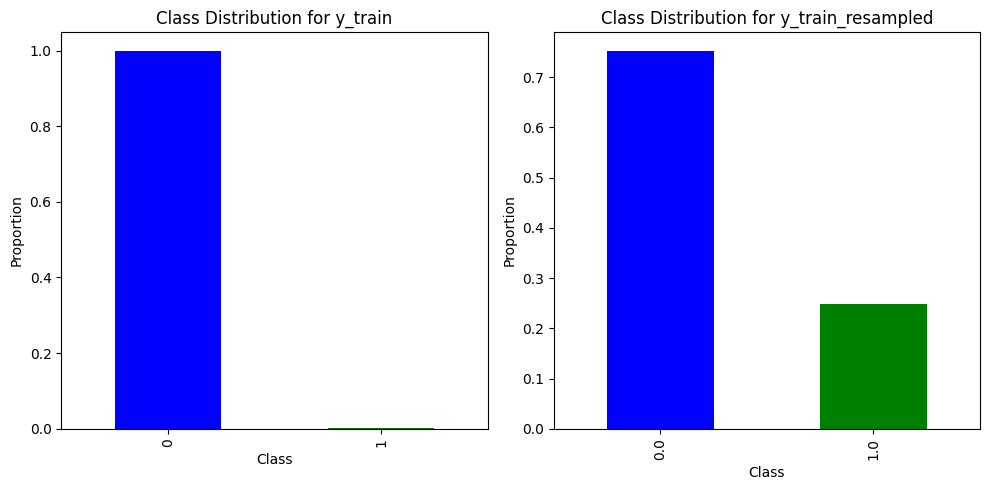

In [35]:
# Calculate class distribution for y_train
class_distribution_train = pd.Series(y_train).value_counts(normalize=True)

# Calculate class distribution for y_train_resampled
class_distribution_resampled = pd.Series(y_train_resampled).value_counts(normalize=True)

# Plotting
plt.figure(figsize=(10, 5))

# Bar chart for y_train
plt.subplot(1, 2, 1)
class_distribution_train.plot(kind='bar', color=['blue', 'green'])
plt.title('Class Distribution for y_train')
plt.xlabel('Class')
plt.ylabel('Proportion')

# Bar chart for y_train_resampled
plt.subplot(1, 2, 2)
class_distribution_resampled.plot(kind='bar', color=['blue', 'green'])
plt.title('Class Distribution for y_train_resampled')
plt.xlabel('Class')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

In [36]:
print(X_train_resampled.shape)
print(X_val.shape)

(56146, 30)
(59810, 30)


## 2. Neural Network iterations



In [15]:
metrics = [
    keras.metrics.Recall(name='recall'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

2024-06-07 13:10:46.659775: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-07 13:10:46.659933: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [39]:


def init_model():
    input_shape = X_train_resampled.shape[1:]
    normalizer = Normalization()
    normalizer.adapt(X_train_resampled)
    
    model = models.Sequential()
    model.add(normalizer)
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

### Regularized model

In [42]:
model = init_model()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ ?                      │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (248.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 61 (248.00 B)

In [50]:
es = EarlyStopping(
    patience=10,
    monitor='val_recall', # We want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train_resampled, y_train_resampled,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64, # Large enough to get a decent chance of containing fraudulent transactions 
                    callbacks=[es], shuffle=True)

Epoch 1/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5687 - prc: 0.4448 - precision: 0.4424 - recall: 0.4083 - val_loss: 0.0609 - val_prc: 0.7181 - val_precision: 0.7222 - val_recall: 0.7573
Epoch 2/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2638 - prc: 0.8824 - precision: 0.8696 - recall: 0.6800 - val_loss: 0.0225 - val_prc: 0.6604 - val_precision: 0.4972 - val_recall: 0.8641
Epoch 3/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1860 - prc: 0.9403 - precision: 0.9189 - recall: 0.8181 - val_loss: 0.0177 - val_prc: 0.7097 - val_precision: 0.4455 - val_recall: 0.8738
Epoch 4/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1539 - prc: 0.9575 - precision: 0.9404 - recall: 0.8625 - val_loss: 0.0164 - val_prc: 0.7265 - val_precision: 0.4099 - val_recall: 0.8835
Epoch 5/100
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1344 - prc: 0.9647 - precision: 0.9557 - recall: 0.8835 - val_loss: 0.0164 - val_prc: 0.7412 - val_precision: 0.3473 - val_recall: 0.

In [43]:
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL

    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()

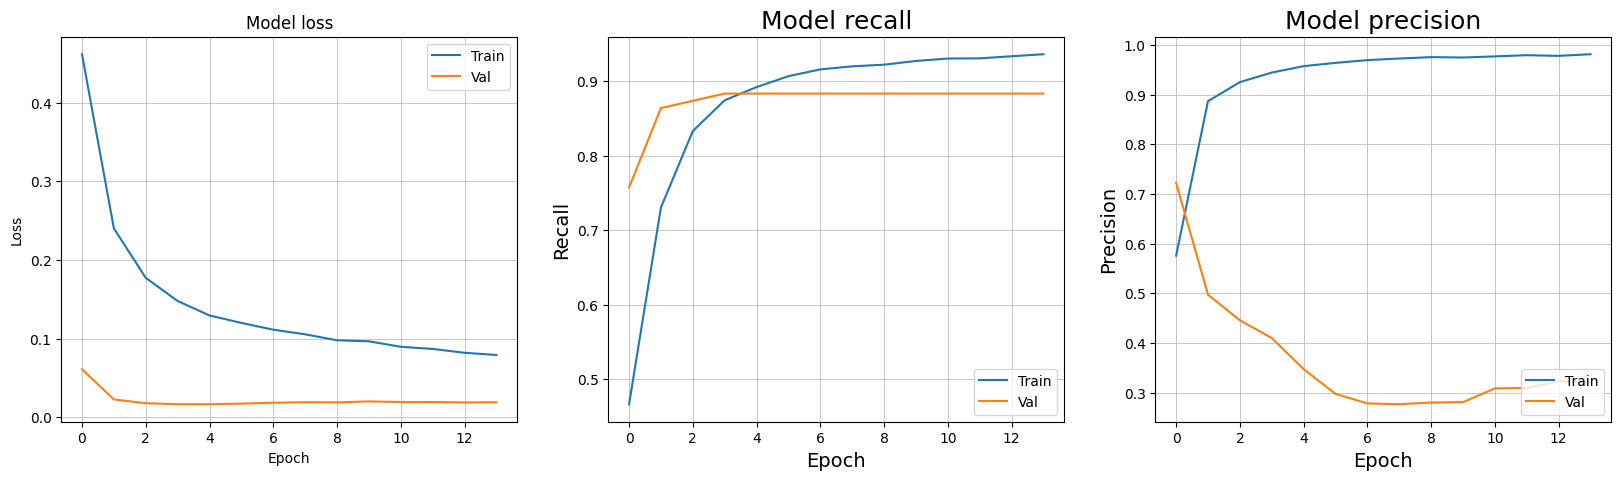

In [51]:
plot_loss_precision_recall_curve(history)

By optimizing on the recall, we sacrified the precision!

However our goal is to detect all the frauds to be detected.

## 3. Score model on the Test set



In [52]:
model.evaluate(X_test, y_test, verbose=0, return_dict=True)

{'loss': 0.016408422961831093,
 'prc': 0.7146095037460327,
 'precision': 0.389776349067688,
 'recall': 0.8243243098258972}

In [53]:
y_pred_proba = model.predict(X_test)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 352us/step


In [54]:
threshold = 0.50 # 50% 

y_pred_binary = np.where(y_pred_proba > threshold, 1, 0 )

### Confusion Matrix

In [55]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_binary)
cm

array([[85104,   191],
       [   26,   122]])

Text(0.5, 25.722222222222214, 'Predicted label')

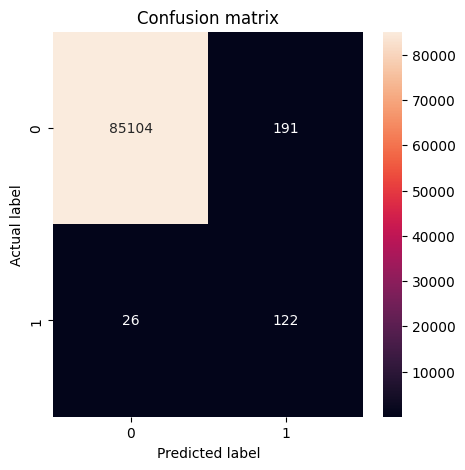

In [56]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [57]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.39      0.82      0.53       148

    accuracy                           1.00     85443
   macro avg       0.69      0.91      0.76     85443
weighted avg       1.00      1.00      1.00     85443



In [58]:
from sklearn.metrics import precision_recall_curve

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)
    plt.plot(recall, precision, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

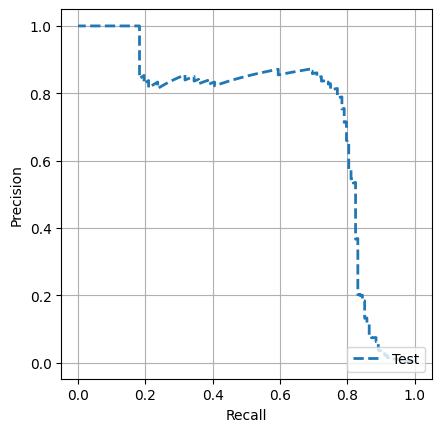

In [59]:
plot_prc("Test", y_test, y_pred_proba, linestyle='--')
plt.legend(loc='lower right')